# Intro to Gradient Boosting

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [551]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

The data is available [here](https://drive.google.com/file/d/1drlRzq-lIY7rxQnvv_3fsxfIfLsjQ4A-/view?usp=sharing)

In [552]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [553]:
filepath = '/content/drive/Othercomputers/My Laptop/data-science-assignments/08 - Gradient Boosting Algorithms/'
filename = 'census_income.xlsx'
filepathname = filepath + filename

Prepare your dataset for modeling.

Remember to: 
1. Check for missing data, bad data, and duplicates.
2. Check your target class balance.
3. Perform your validation split
4. Create a preprocessing pipeline to use with your models.
5. Fit and evaluate your models using pipelines

In [554]:
df = pd.read_excel(filepathname, header=0)

In [555]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income-class    32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [556]:
column_features = ['age','workclass','education','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income-class']
target = 'income-class'

In [557]:
df.groupby(column_features,dropna=False, as_index=False)[['Unnamed: 0']].count()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class,Unnamed: 0
0,17,?,10th,Never-married,?,Other-relative,White,Male,0,0,6,United-States,<=50K,1
1,17,?,10th,Never-married,?,Other-relative,White,Male,0,0,12,United-States,<=50K,1
2,17,?,10th,Never-married,?,Own-child,Black,Female,0,0,40,United-States,<=50K,1
3,17,?,10th,Never-married,?,Own-child,Black,Male,0,0,20,United-States,<=50K,1
4,17,?,10th,Never-married,?,Own-child,Other,Female,0,0,20,United-States,<=50K,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29091,90,Private,Some-college,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K,2
29092,90,Private,Some-college,Separated,Adm-clerical,Own-child,White,Female,0,0,40,Puerto-Rico,<=50K,1
29093,90,Self-emp-not-inc,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,10566,0,50,United-States,<=50K,1
29094,90,Self-emp-not-inc,HS-grad,Never-married,Exec-managerial,Not-in-family,White,Male,2964,0,12,United-States,<=50K,1


In [558]:
df.nunique()

Unnamed: 0        32561
age                  73
workclass             9
education            16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
income-class          2
dtype: int64

In [ ]:
for feature in column_features:
    print("Name of Feature:",feature)
    print(df[feature].value_counts(normalize=True))
    print("\n")

In [560]:
# Cell above shows features with rows with the value of "?"
# Dropping rows from the dataframe that contain the value "?"
# The three features identified with this value are:

#print("Number of rows in dataframe prior to rows being deleted: {:,.0f}".format(df.shape[0]))
num_rows = 0
missing_values = ['workclass','occupation','native-country']
for feature in missing_values:
    df_filter = df[df[feature] == '?']
    num_rows += df_filter.shape[0]
    print("Number of rows to be dropped: {:,.0f} with value of '?' in feature {}".format(df_filter.shape[0],feature))
    df.drop(df_filter.index, inplace = True)
print("Total number of rows deleted: {:,.0f}".format(num_rows))
print("Number of rows in dataframe after rows are deleted: {:,.0f}".format(df.shape[0]))

In [561]:
# Dropping column Unnamed: 0
df.drop(columns='Unnamed: 0', inplace=True)

In [562]:
# Creating the column selectors and one hot encoder
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include="object")
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [563]:
# Creating an instance of StandardScaler
scaler = StandardScaler()

In [564]:
# Setting up the tuples for column transformer
scaler_tuple = (scaler, num_selector)
ohe_tuple = (one_hot_encoder, cat_selector)

In [565]:
# Creating an instance of column transformer
column_transformer = make_column_transformer(scaler_tuple, ohe_tuple)

In [566]:
y = df['income-class']
X = df.drop(columns='income-class')

In [567]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [568]:
myBoostClassifier = XGBClassifier()
pipe = make_pipeline(column_transformer, myBoostClassifier)
myTitle = "eXtreme Gradient Classifier"

In [569]:
%%time
pipe.fit(X_train, y_train)

CPU times: user 5.25 s, sys: 76.6 ms, total: 5.32 s
Wall time: 5.29 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff362da1a10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff362da1f10>)])),
                ('xgbclassifier', XGBClassifier())])

In [570]:
print(myTitle)
print(metrics.classification_report(y_test, pipe.predict(X_test)))

eXtreme Gradient Classifier
              precision    recall  f1-score   support

       <=50K       0.87      0.95      0.91      6172
        >50K       0.80      0.57      0.66      1969

    accuracy                           0.86      8141
   macro avg       0.84      0.76      0.79      8141
weighted avg       0.86      0.86      0.85      8141



Which target class is your model better at predicting?  Is it significantly overfit?

##Better at predicting less than or equal to 50K
##Doesn't appear to be significantly overfit

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

In [571]:
myBoostClassifier = LGBMClassifier()
pipe = make_pipeline(column_transformer, myBoostClassifier)
myTitle = "LightGBM Boost Classifier"
myDefParams = myBoostClassifier.get_params()

In [572]:
%%time
pipe.fit(X_train, y_train)

CPU times: user 550 ms, sys: 6.93 ms, total: 557 ms
Wall time: 570 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff362da1a10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff362da1f10>)])),
                ('lgbmclassifier', LGBMClassifier())])

In [573]:
print(myTitle)
def_predictions = pipe.predict(X_test)
myDefClassReport = metrics.classification_report(y_test, def_predictions)
myDefConfMat = metrics.confusion_matrix(y_test, def_predictions)
print(myDefClassReport)

LightGBM Boost Classifier
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6172
        >50K       0.78      0.66      0.71      1969

    accuracy                           0.87      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.87      0.87      8141



## GradientBoostingClassifier

In [574]:
myBoostClassifier = GradientBoostingClassifier()
pipe = make_pipeline(column_transformer, myBoostClassifier)
myTitle = "Gradient Boost Classifier"

In [575]:
%%time
pipe.fit(X_train, y_train)

CPU times: user 5.39 s, sys: 10.2 ms, total: 5.4 s
Wall time: 5.38 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff362da1a10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff362da1f10>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [576]:
print(myTitle)
print(metrics.classification_report(y_test, pipe.predict(X_test)))

Gradient Boost Classifier
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      6172
        >50K       0.80      0.58      0.67      1969

    accuracy                           0.86      8141
   macro avg       0.84      0.77      0.79      8141
weighted avg       0.86      0.86      0.86      8141




# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


#Selecting the LightGBM based on it time of 451 milliseconds and higher scores on precision for both classes

In [577]:
myDefParams

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [578]:
# Setting up the parameter grid
param_grid = {
    'n_estimators': [100,150],
    'num_leaves': [10,30],
    'max_depth': [2,6],
    'learning_rate':[0.05,0.2],
    'random_state':[32,42,52],
    'class_weight':['balanced',None]
}

In [579]:
myBoostClassifier = LGBMClassifier()

X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

pipe = GridSearchCV(estimator=myBoostClassifier,param_grid=param_grid)
myTitle = "LightGBM Boost Classifier with Parameters Adjusted"

myAdjParams = pipe.get_params()
myAdjParams

{'cv': None,
 'error_score': nan,
 'estimator': LGBMClassifier(),
 'estimator__boosting_type': 'gbdt',
 'estimator__class_weight': None,
 'estimator__colsample_bytree': 1.0,
 'estimator__importance_type': 'split',
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': -1,
 'estimator__min_child_samples': 20,
 'estimator__min_child_weight': 0.001,
 'estimator__min_split_gain': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': -1,
 'estimator__num_leaves': 31,
 'estimator__objective': None,
 'estimator__random_state': None,
 'estimator__reg_alpha': 0.0,
 'estimator__reg_lambda': 0.0,
 'estimator__silent': True,
 'estimator__subsample': 1.0,
 'estimator__subsample_for_bin': 200000,
 'estimator__subsample_freq': 0,
 'n_jobs': None,
 'param_grid': {'class_weight': ['balanced', None],
  'learning_rate': [0.05, 0.2],
  'max_depth': [2, 6],
  'n_estimators': [100, 150],
  'num_leaves': [10, 30],
  'random_state': [32, 42, 52]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'retur

In [580]:
%%time
pipe.fit(X_train, y_train)

CPU times: user 2min 48s, sys: 1.4 s, total: 2min 50s
Wall time: 2min 49s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.05, 0.2], 'max_depth': [2, 6],
                         'n_estimators': [100, 150], 'num_leaves': [10, 30],
                         'random_state': [32, 42, 52]})

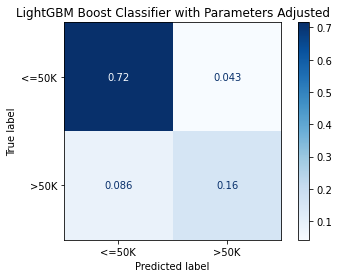

LightGBM Boost Classifier with Parameters Adjusted
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92      6172
        >50K       0.78      0.64      0.71      1969

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.87      0.87      0.87      8141



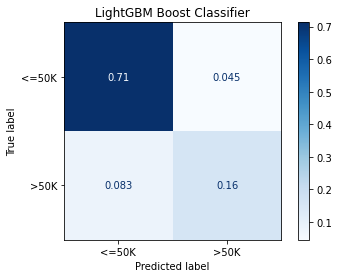

LightGBM Boost Classifier
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      6172
        >50K       0.78      0.66      0.71      1969

    accuracy                           0.87      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.87      0.87      8141



In [581]:
adj_predictions = pipe.predict(X_test)
myAdjClassReport = metrics.classification_report(y_test, adj_predictions)
myAdjConfMat = metrics.confusion_matrix(y_test, adj_predictions)

disp = ConfusionMatrixDisplay.from_predictions(y_test, adj_predictions, cmap='Blues',normalize='all');
disp.ax_.set_title(myTitle)
plt.show()
print(myTitle)
print(myAdjClassReport)

myTitle = "LightGBM Boost Classifier"
disp = ConfusionMatrixDisplay.from_predictions(y_test, def_predictions, cmap='Blues',normalize='all');
disp.ax_.set_title(myTitle)
plt.show()
print(myTitle)
print(myDefClassReport)

# Evaluation

Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

# The model is better at predicting who will make less than $50K based on the recall percentage. The accuracy is the same.
# The hypertuning provided an additional 1% increase in classifying true negatives.
# The computation time is significant, ran this model on an i9 Core and still took about 5 minutes, a large dataset with more features would take longer and run slower. It is worth comparing Boosting to other non-Boosting classification models.

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

